## XGBoost Classifier for the cancer diagnosis

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install shap

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
import shap

In [6]:
import xgboost as xgb

In [7]:
project_path = "/content/drive/MyDrive/Colab Notebooks/cancer_diagnosis/"
data_path = project_path + "data/"

In [8]:
data_df = pd.read_csv(data_path + "data.csv")
data_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [10]:
columns_to_drop = ["id", "Unnamed: 32"]
data_df = data_df.drop(columns=columns_to_drop, axis = 1)

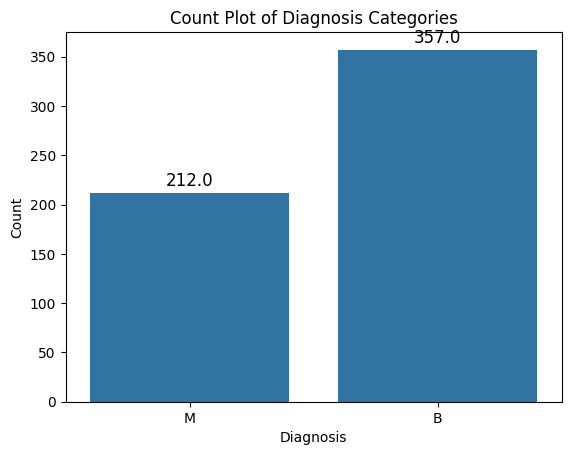

In [11]:
ax = sns.countplot(x="diagnosis", data=data_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Count Plot of Diagnosis Categories')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [12]:
y = data_df["diagnosis"].values
labelencoder = LabelEncoder()
labelencoder = labelencoder.fit(y)
Y = labelencoder.transform(y)
print(np.unique(Y))

[0 1]


In [13]:
labelencoder.inverse_transform(np.array([0, 1]))

array(['B', 'M'], dtype=object)

In [14]:
X = data_df.drop(columns = ["diagnosis"], axis = 1)
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Feature Scaling

In [15]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(569, 30)

### Train Test Split

In [16]:
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595


In [17]:
X_train, X_rem, y_train, y_rem = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size = 0.5, random_state = 42)
print("Shape of training data is  : ", X_train.shape, y_train.shape)
print("Shape of validation data is : ", X_val.shape, y_val.shape)
print("Shape of test data is : ", X_test.shape, y_test.shape)

Shape of training data is  :  (455, 30) (455,)
Shape of validation data is :  (57, 30) (57,)
Shape of test data is :  (57, 30) (57,)


### XGBoost Clasisifer

In [18]:
xgb_model = xgb.XGBClassifier(random_state = 42)
xgb_model.fit(X_train, y_train)
xgb_train_predictions = xgb_model.predict(X_train)
xgb_val_predictions = xgb_model.predict(X_val)
xgb_test_predictions = xgb_model.predict(X_test)

### Probability Prediction

In [19]:
xgb_train_probabilities = xgb_model.predict_proba(X_train)
xgb_val_probabilities = xgb_model.predict_proba(X_val)
xgb_test_probabilities = xgb_model.predict_proba(X_test)

print(xgb_train_probabilities.shape, xgb_val_probabilities.shape, xgb_test_probabilities.shape)

(455, 2) (57, 2) (57, 2)


In [20]:
def get_prediction_probability_class(train_prob, val_prob, test_prob, class_type = "class 0"):
  train_df = pd.DataFrame(train_prob, columns = ["class 0", "class 1"])
  val_df = pd.DataFrame(val_prob, columns = ["class 0", "class 1"])
  test_df = pd.DataFrame(test_prob, columns = ["class 0", "class 1"])

  sns.kdeplot(train_df[class_type], fill = True, color="red", label = "train class 0")
  sns.kdeplot(val_df[class_type], fill = True, color="blue", label = "val class 0")
  sns.kdeplot(test_df[class_type], fill = True, color="green", label = "test class 0")

  plt.title(f"{class_type} Density plot of predicted probabilities")
  plt.xlabel("Predicited Probability")
  plt.ylabel("Density")
  plt.legend()
  plt.show()
  print()

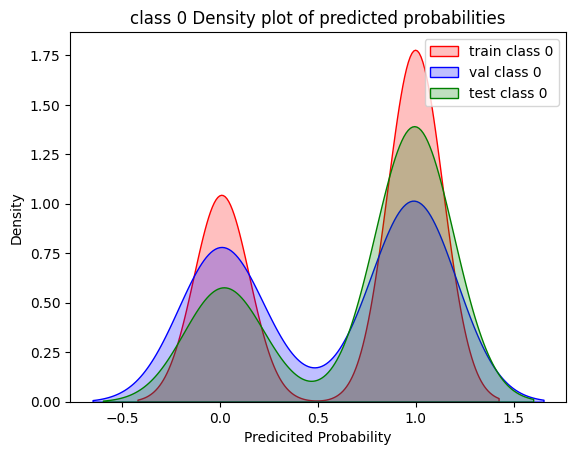

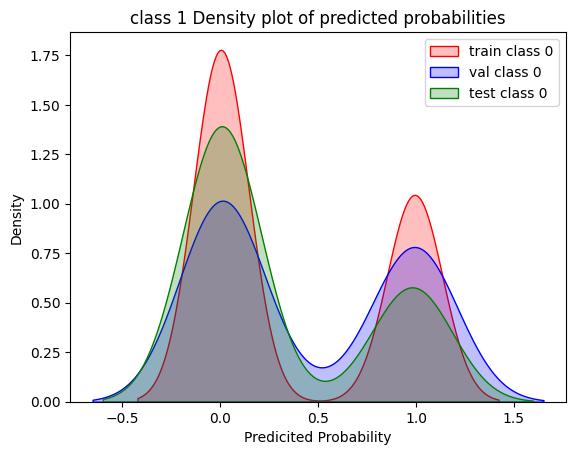

In [21]:
get_prediction_probability_class(xgb_train_probabilities, xgb_val_probabilities, xgb_test_probabilities, class_type = "class 0")
get_prediction_probability_class(xgb_train_probabilities, xgb_val_probabilities, xgb_test_probabilities, class_type = "class 1")

In [22]:
def get_prediction_probability_kde(probabilities, split = ""):
  probabilities_df = pd.DataFrame(probabilities, columns = ["class 0", "class 1"])
  sns.kdeplot(probabilities_df["class 0"], fill = True, color="blue", label = "class 0")
  sns.kdeplot(probabilities_df["class 1"], fill = True, color="red", label = "class 1")

  plt.title(f"{split} Density plot of predicted probabilities")
  plt.xlabel("Predicited Probability")
  plt.ylabel("Density")

  plt.legend()
  plt.show()
  print()

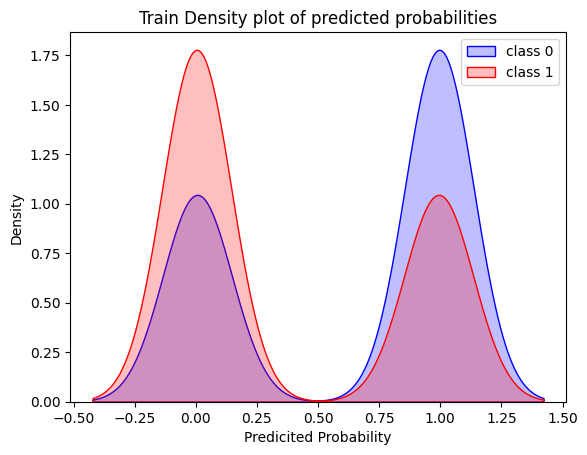

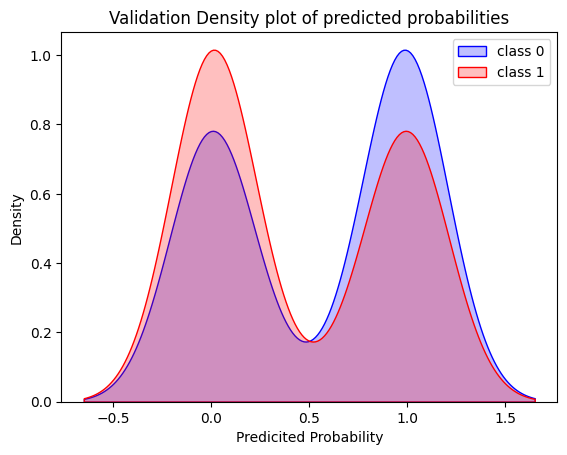

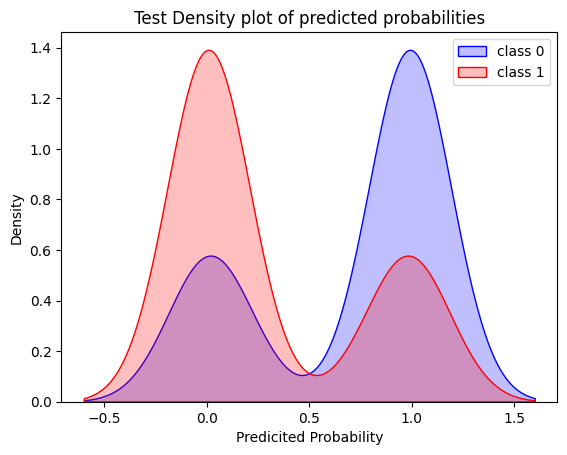

In [23]:
get_prediction_probability_kde(xgb_train_probabilities, split = "Train")
get_prediction_probability_kde(xgb_val_probabilities, split = "Validation")
get_prediction_probability_kde(xgb_test_probabilities, split = "Test")

### Evaluation

In [24]:
def get_classification_report(y_true, y_pred, title = "classification report"):
  print(title)
  xgb_model_report = classification_report(y_true, y_pred)
  print(xgb_model_report)

def get_confusion_heatmap(y_true, y_pred, title = "confusion matrix"):
  xgb_cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(xgb_cm, annot = True)
  plt.title(title)
  plt.show()
  print()

In [25]:
get_classification_report(y_train, xgb_train_predictions, title = "train classification report")
get_classification_report(y_val, xgb_val_predictions, title = "val classification report")
get_classification_report(y_test, xgb_test_predictions, title = "test classification report")


train classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       286
           1       1.00      1.00      1.00       169

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

val classification report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.89      0.92        27

    accuracy                           0.93        57
   macro avg       0.93      0.93      0.93        57
weighted avg       0.93      0.93      0.93        57

test classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        41
           1       0.94      1.00      0.97        16

    accuracy                           0.98        57
   macro avg       0.97      0.99      0.98    

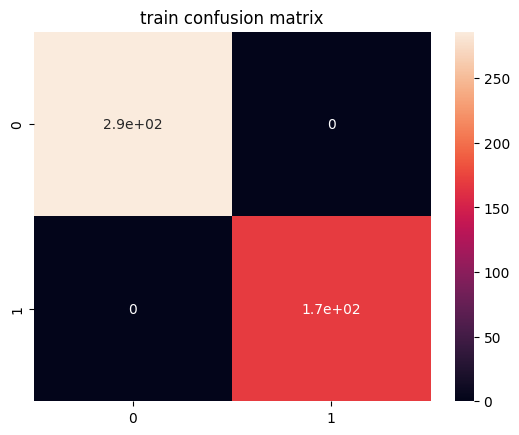

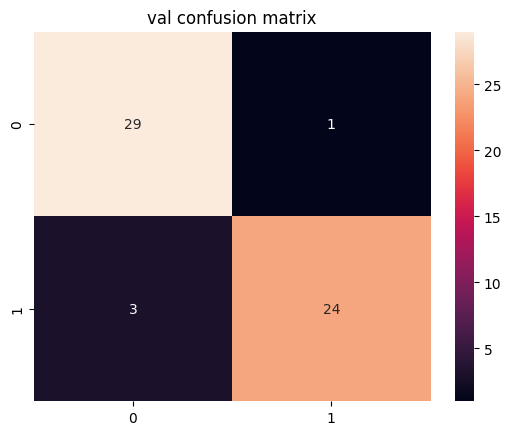

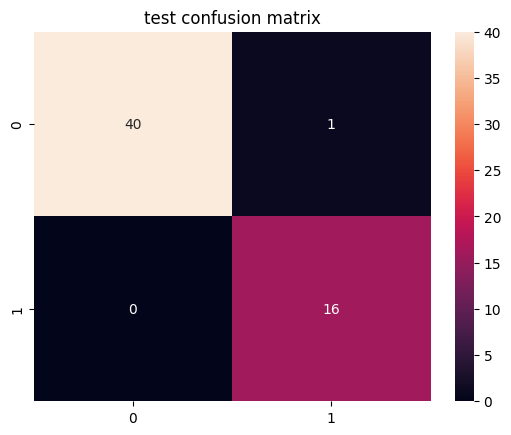

In [26]:
get_confusion_heatmap(y_train, xgb_train_predictions, title = "train confusion matrix")
get_confusion_heatmap(y_val, xgb_val_predictions, title = "val confusion matrix")
get_confusion_heatmap(y_test, xgb_test_predictions, title = "test confusion matrix")


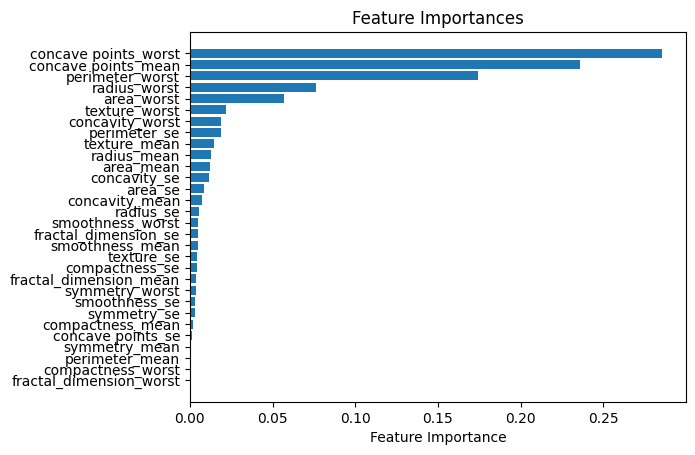

In [27]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.show()

## Shap Explainer

In [55]:
xgb_model.predict(X_test)

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0])

In [38]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

In [39]:
print(shap_values.shape, type(shap_values), X_test.shape, type(X_test))

(57, 30) <class 'numpy.ndarray'> (57, 30) <class 'pandas.core.frame.DataFrame'>


**It is model agnostic and uses the shapley values from game theory to estimate how does each feature contribute to the prediction**


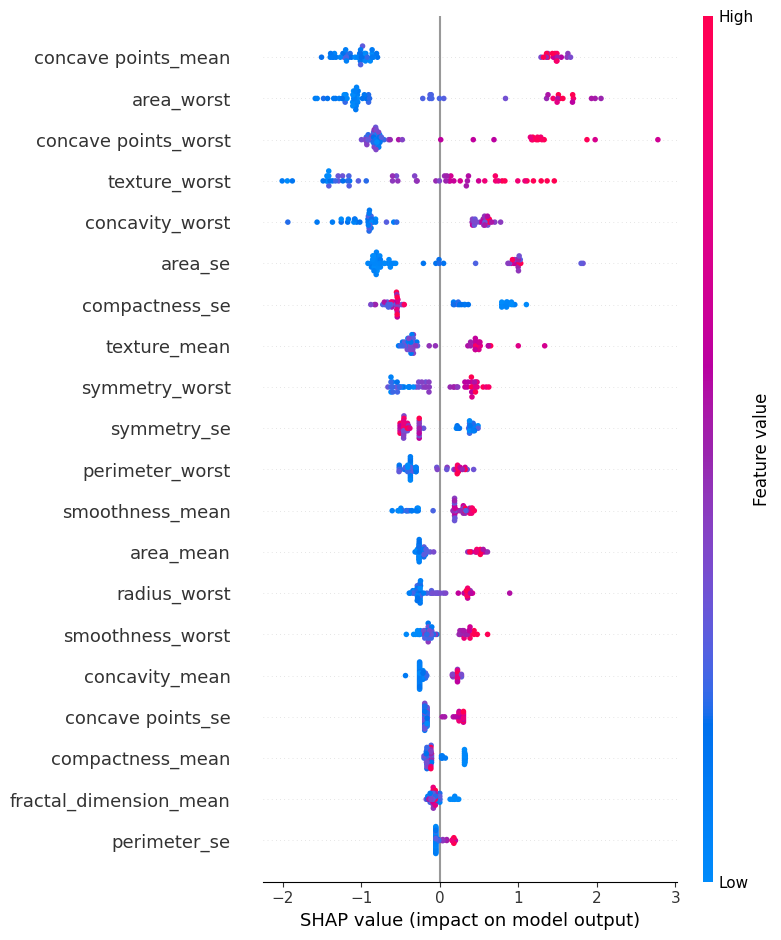

In [40]:
# visualize the feature importance
shap.summary_plot(shap_values, X_test, show=False, plot_type="dot", class_names=["Malignant", "Benign"])

In [49]:
X_test_np = X_test.to_numpy()

In [57]:
index = 6
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], X_test_np[index], feature_names=X_test.columns)

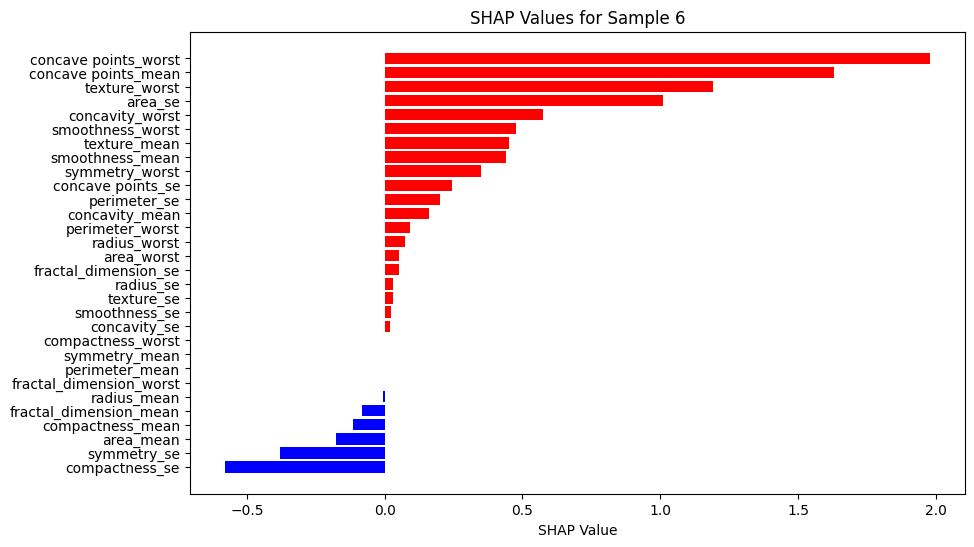

In [58]:
index = 6
feature_names = X_test.columns

shap_df = pd.DataFrame({
    "feature" : feature_names,
    "SHAP value" : shap_values[index]
})
shap_df = shap_df.sort_values(by="SHAP value", ascending = False)


colors = ['red' if value > 0 else 'blue' for value in shap_df['SHAP value']]


plt.figure(figsize=(10, 6))
bars = plt.barh(shap_df['feature'], shap_df['SHAP value'], color=colors)
plt.xlabel('SHAP Value')
plt.title(f'SHAP Values for Sample {index}')
plt.gca().invert_yaxis()
plt.show()

### Inference

In [34]:
# original prediction for this data is malignant
new_data = X.iloc[0]
new_data = new_data.to_frame().T.copy()

In [35]:
new_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [36]:
def predict_pipeline(new_data, scaler, labelencoder):
  scaler.transform(new_data)
  pred = xgb_model.predict(new_data)
  print(labelencoder.inverse_transform(pred))

In [37]:
predict_pipeline(new_data, scaler, labelencoder)

['M']
